# Классификация автомобилей.

В проекте будем обучать нейронную сеть для классификации модели автомобиля по фотографии.

### Импортируем библиотеки.

In [1]:
import os, re, math, random, time, gc, string, pickle, shutil, pathlib, itertools, zipfile
import numpy as np, pandas as pd, matplotlib.pyplot as plt, PIL

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.activations import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers.experimental.preprocessing import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.backend import clear_session

from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm

Для начала ознакомимся с нашими данными:

In [2]:
train_df = pd.read_csv('../input/sf-dl-car-classification/train.csv')
sample_submission = pd.read_csv('../input/sf-dl-car-classification/sample-submission.csv')
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [4]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Распределение классов достаточно равномерное - это хорошо.

In [5]:
print('Распаковываем картинки')

for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/sf-dl-car-classification/"+data_zip,"r") as z:
        z.extractall('../')
        
print(os.listdir('../'))

Распаковываем картинки
['src', 'test_upload', 'lib', 'input', 'train', 'working']


Пример картинок (random sample)


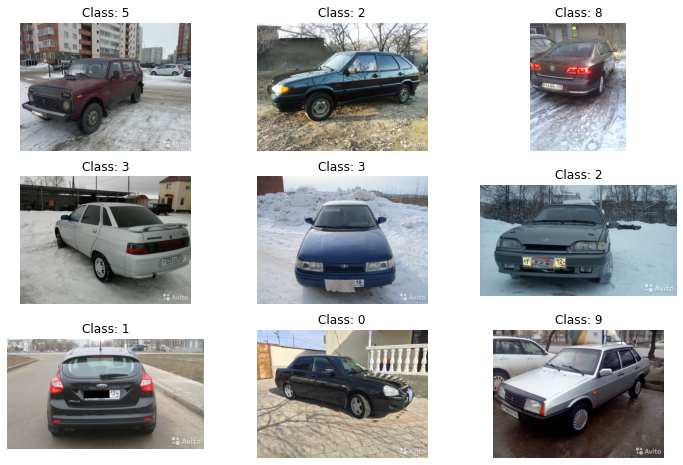

In [6]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open('../' + f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

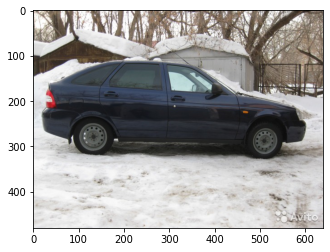

(640, 480)

In [7]:
image = PIL.Image.open('../train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

## Подготовка данных

Подключаем генераторы данных ImageDataGenerator с разделением на тренировочную и валидационную части в соотношении 80/20%. А также генератор для тестовой части данных, с которой мы будем делать сабмишн.

In [8]:
'''train_datagen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1/255)'''

'train_datagen = ImageDataGenerator(rescale = 1/255, validation_split = 0.2)\n\ntest_datagen = ImageDataGenerator(rescale = 1/255)'

## Аугментации

Для дальнейшего повышения качества сделаем аугментацию тренировочных данных с помощью модуля ImageDataGenerator.

In [9]:
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   validation_split = 0.2,
                                   rotation_range = 10, 
                                   width_shift_range = 0.1, 
                                   height_shift_range = 0.1, 
                                   shear_range = 0.1, 
                                   zoom_range = 0.1, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1/255)

In [10]:
train_generator = train_datagen.flow_from_directory(
    '../train/',      # директория где расположены папки с картинками 
    target_size = (320,320),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True, seed = 0,
    subset = 'training')

test_generator = train_datagen.flow_from_directory(
    '../train/',
    target_size = (320,320),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = True, seed = 0,
    subset = 'validation')

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe = sample_submission,
    directory = '../test_upload/',
    x_col = "Id",
    y_col = None,
    shuffle = False,
    class_mode = None,
    seed = 0,
    target_size = (320,320),
    batch_size = 32)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


Генератор выдал 12452 картинки для трэйна и 3109 - для теста. Каждая часть данных имеет по 10 классов. Также мы получили 6675 картинок для сабмишна. Посмотрим на некоторые случайные фото из train_generator.

Пример картинок из train_generator


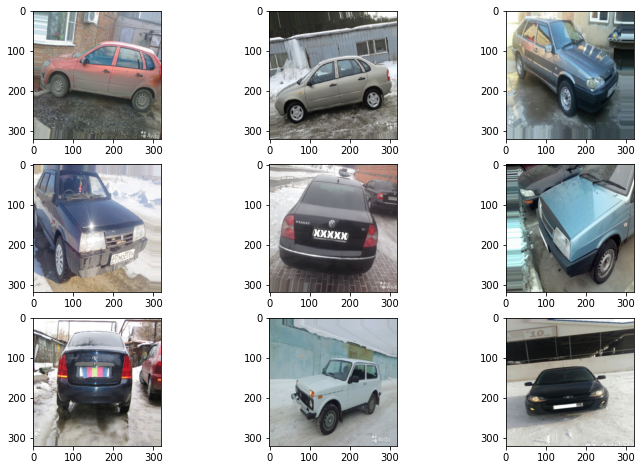

In [11]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

## Построение модели

Для построения модели возьмем предобученную сеть **Xception** из модуля keras.applications.

In [12]:
clear_session()

Попробуем обучить модель с тонкой настройкой (fine-tuning). Для начала загрузим модель Xception.

### Шаг 1

In [13]:
base_model = Xception(weights = 'imagenet', include_top=False, input_shape = (320, 320, 3))

83689472/83683744 [==============================] - 1s 0us/step


Указываем, что сеть Xception не обучается.

In [14]:
base_model.trainable = False

Добавляем ее в общую структуру.

In [15]:
model = Sequential([
    base_model,
    GlobalMaxPool2D(),
    Dense(256, activation='relu'),
    Dropout(0.25), 
    Dense(10)
])

model.compile(loss = CategoricalCrossentropy(from_logits = True), optimizer = Adam(ExponentialDecay(0.001, 100, 0.9)), 
              metrics='accuracy')

Использование модели **Xception** дало значение метрики accuracy 82%.

Попробуем взять другую предобученную сеть - **ResNet50V2** из keras.applications.

In [16]:
''''model = Sequential([
    ResNet50V2(weights = 'imagenet', include_top=False, input_shape = (90, 120, 3)),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.25), 
    Dense(10)
])

model.compile(loss = CategoricalCrossentropy(from_logits=True), optimizer=Adam(ExponentialDecay(1e-3, 100, 0.9)), 
              metrics='accuracy')'''

"'model = Sequential([\n    ResNet50V2(weights = 'imagenet', include_top=False, input_shape = (90, 120, 3)),\n    GlobalAveragePooling2D(),\n    Dense(256, activation='relu'),\n    Dropout(0.25), \n    Dense(10)\n])\n\nmodel.compile(loss = CategoricalCrossentropy(from_logits=True), optimizer=Adam(ExponentialDecay(1e-3, 100, 0.9)), \n              metrics='accuracy')"

Модель **ResNet50V2** показывает accuracy равное 73%. Это на 9% хуже, чем с моделью **Xception**.

Проверим сеть **EfficientNetB5**.

In [17]:
'''model = Sequential([
    EfficientNetB5(weights = 'imagenet', include_top = False, input_shape = (90, 120, 3)),
    GlobalAveragePooling2D(),
    Dense(256, activation = 'relu'),
    Dropout(0.25), 
    Dense(10)
])

model.compile(loss = CategoricalCrossentropy(from_logits = True), optimizer=Adam(ExponentialDecay(1e-3, 100, 0.9)), 
              metrics = 'accuracy')'''

"model = Sequential([\n    EfficientNetB5(weights = 'imagenet', include_top = False, input_shape = (90, 120, 3)),\n    GlobalAveragePooling2D(),\n    Dense(256, activation = 'relu'),\n    Dropout(0.25), \n    Dense(10)\n])\n\nmodel.compile(loss = CategoricalCrossentropy(from_logits = True), optimizer=Adam(ExponentialDecay(1e-3, 100, 0.9)), \n              metrics = 'accuracy')"

Модель **EfficientNetB5** дает accuracy 79%. Это на 3% меньше, чем показывает сеть **Xception**.

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 21,388,594
Trainable params: 527,114
Non-trainable params: 20,861,480
_________________________________________________________________


В результате сравнения трех предобученных сетей **Xception**, **ResNet50V2** и **EfficientNetB5** лучше всего себя показала сеть **Xception**. Дальше будем работать с ней.

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [19]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

Обучаем:

In [20]:
history = model.fit(
    train_generator, 
    steps_per_epoch = len(train_generator), 
    validation_data = test_generator, 
    validation_steps = len(test_generator), 
    epochs = 10, 
    callbacks = callbacks_list
)

Epoch 1/10
390/390 [==============================] - 424s 1s/step - loss: 1.9963 - accuracy: 0.3524 - val_loss: 1.2107 - val_accuracy: 0.5606

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
390/390 [==============================] - 413s 1s/step - loss: 1.2521 - accuracy: 0.5440 - val_loss: 1.0766 - val_accuracy: 0.6018

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
390/390 [==============================] - 413s 1s/step - loss: 1.1366 - accuracy: 0.5877 - val_loss: 1.0164 - val_accuracy: 0.6333

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
390/390 [==============================] - 415s 1s/step - loss: 1.0608 - accuracy: 0.6130 - val_loss: 0.9636 - val_accuracy: 0.6645

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
390/390 [==============================] - 415s 1s/step - loss: 1.0097 - accuracy: 0.6288 - val_loss: 0.9207 - val_accuracy: 0.6735

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
390/390 [==============================] - 4

In [21]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [22]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

98/98 [==============================] - 85s 863ms/step - loss: 0.8835 - accuracy: 0.6845
Accuracy: 68.45%


Посмотрим на графики обучения:

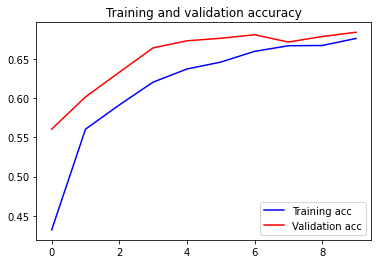

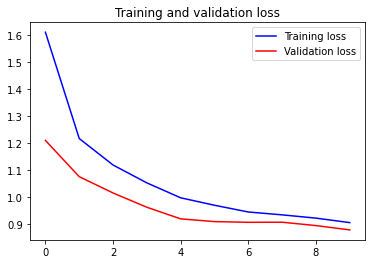

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Шаг 2

Посмотрим сколько слоев в базовой модели.

In [24]:
len(base_model.layers)

132

Разморозим половину слоев (60) и снова обучим сеть.

In [25]:
base_model.trainable = True

for layer in base_model.layers[:60]:
    layer.trainable = False

In [26]:
len(base_model.trainable_variables)

87

In [27]:
model.compile(loss = CategoricalCrossentropy(from_logits = True), optimizer = Adam(ExponentialDecay(0.001, 100, 0.9)), 
              metrics='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 21,388,594
Trainable params: 16,461,362
Non-trainable params: 4,927,232
_________________________________________________________________


In [28]:
history = model.fit(
    train_generator, 
    steps_per_epoch = len(train_generator), 
    validation_data = test_generator, 
    validation_steps = len(test_generator), 
    epochs = 10, 
    callbacks = callbacks_list
)

Epoch 1/10
390/390 [==============================] - 452s 1s/step - loss: 0.9330 - accuracy: 0.6587 - val_loss: 0.4583 - val_accuracy: 0.8665

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
390/390 [==============================] - 449s 1s/step - loss: 0.2288 - accuracy: 0.9218 - val_loss: 0.2011 - val_accuracy: 0.9286

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
390/390 [==============================] - 449s 1s/step - loss: 0.1513 - accuracy: 0.9449 - val_loss: 0.1788 - val_accuracy: 0.9427

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
390/390 [==============================] - 456s 1s/step - loss: 0.0992 - accuracy: 0.9642 - val_loss: 0.1420 - val_accuracy: 0.9534

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
390/390 [==============================] - 458s 1s/step - loss: 0.0612 - accuracy: 0.9776 - val_loss: 0.1569 - val_accuracy: 0.9524

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
390/390 [==============================] - 4

In [29]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [30]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

98/98 [==============================] - 86s 872ms/step - loss: 0.1643 - accuracy: 0.9588
Accuracy: 95.88%


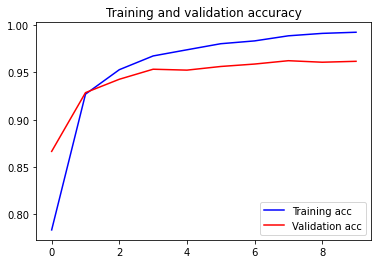

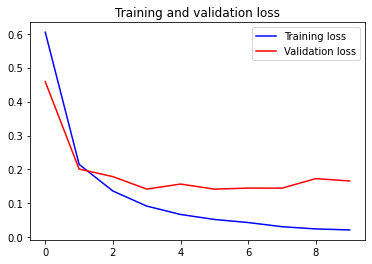

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Шаг 3

Продолжим тонкую настройку сети. Теперь разморозим 3/4 слоев и опять обучим сеть.

In [32]:
base_model.trainable = True

for layer in base_model.layers[:30]:
    layer.trainable = False
    
len(base_model.trainable_variables)    

122

In [33]:
model.compile(loss = CategoricalCrossentropy(from_logits = True), 
              optimizer = Adam(ExponentialDecay(0.001, 100, 0.9)), 
              metrics='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 21,388,594
Trainable params: 20,953,122
Non-trainable params: 435,472
_________________________________________________________________


In [34]:
history = model.fit(
    train_generator, 
    steps_per_epoch = len(train_generator), 
    validation_data = test_generator, 
    validation_steps = len(test_generator), 
    epochs = 10, 
    callbacks = callbacks_list
)

Epoch 1/10
390/390 [==============================] - 474s 1s/step - loss: 0.3120 - accuracy: 0.9026 - val_loss: 0.3825 - val_accuracy: 0.8836

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
390/390 [==============================] - 473s 1s/step - loss: 0.1543 - accuracy: 0.9487 - val_loss: 0.1523 - val_accuracy: 0.9518

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
390/390 [==============================] - 475s 1s/step - loss: 0.0886 - accuracy: 0.9688 - val_loss: 0.1366 - val_accuracy: 0.9592

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
390/390 [==============================] - 478s 1s/step - loss: 0.0560 - accuracy: 0.9780 - val_loss: 0.1274 - val_accuracy: 0.9585

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
390/390 [==============================] - 480s 1s/step - loss: 0.0418 - accuracy: 0.9825 - val_loss: 0.1473 - val_accuracy: 0.9572

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
390/390 [==============================] - 4

In [35]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [36]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

98/98 [==============================] - 90s 918ms/step - loss: 0.1922 - accuracy: 0.9592
Accuracy: 95.92%


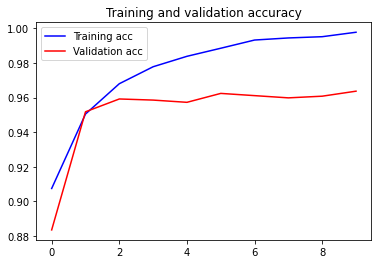

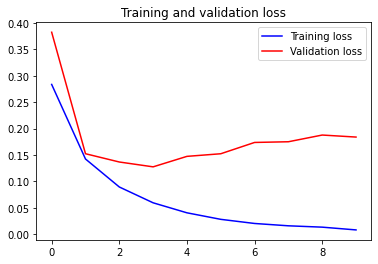

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Шаг 4

Разморозим всю сеть.

In [38]:
base_model.trainable = True

model.compile(loss = CategoricalCrossentropy(from_logits = True), optimizer = Adam(ExponentialDecay(0.001, 100, 0.9)), 
              metrics='accuracy')

Снова обучим сеть.

In [39]:
history = model.fit(
    train_generator, 
    steps_per_epoch = len(train_generator), 
    validation_data = test_generator, 
    validation_steps = len(test_generator), 
    epochs = 15, 
    callbacks = callbacks_list
)

Epoch 1/15
390/390 [==============================] - 569s 1s/step - loss: 0.2269 - accuracy: 0.9294 - val_loss: 0.4374 - val_accuracy: 0.8768

Epoch 00001: saving model to best_model.hdf5
Epoch 2/15
390/390 [==============================] - 553s 1s/step - loss: 0.1534 - accuracy: 0.9533 - val_loss: 0.1678 - val_accuracy: 0.9476

Epoch 00002: saving model to best_model.hdf5
Epoch 3/15
390/390 [==============================] - 550s 1s/step - loss: 0.0674 - accuracy: 0.9758 - val_loss: 0.1573 - val_accuracy: 0.9508

Epoch 00003: saving model to best_model.hdf5
Epoch 4/15
390/390 [==============================] - 547s 1s/step - loss: 0.0487 - accuracy: 0.9819 - val_loss: 0.1180 - val_accuracy: 0.9601

Epoch 00004: saving model to best_model.hdf5
Epoch 5/15
390/390 [==============================] - 545s 1s/step - loss: 0.0352 - accuracy: 0.9902 - val_loss: 0.1270 - val_accuracy: 0.9627

Epoch 00005: saving model to best_model.hdf5
Epoch 6/15
390/390 [==============================] - 5

In [40]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [41]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

98/98 [==============================] - 89s 905ms/step - loss: 0.1740 - accuracy: 0.9675
Accuracy: 96.75%


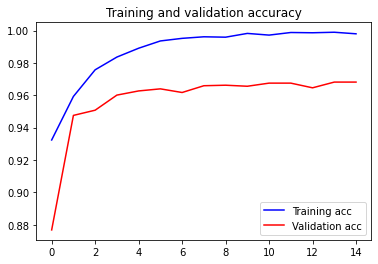

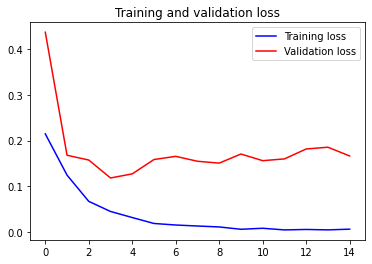

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Test-time augmentations (TTA)

Для дальнейшего повышения качества предсказаний применим метод TTA.

Сделаем предсказания 5 раз.

In [43]:
predictions = []
for _ in range(5): 
    predictions.append(model.predict(test_sub_generator, verbose=1)) 
    test_sub_generator.reset()
predictions = np.array(predictions)
predictions.shape

209/209 [==============================] - 61s 292ms/step


(5, 6675, 10)

In [44]:
final_predictions = predictions.mean(axis=0).argmax(axis=-1)

In [45]:
submission = pd.DataFrame({
    'Id': test_sub_generator.filenames,
    'Category': final_predictions
}, columns=['Id', 'Category'])
submission.to_csv('submission.csv', index=False)

print('Save submit')

Save submit


In [46]:
'''predictions = model.predict(test_sub_generator, verbose=1)
predictions = predictions.argmax(axis=1)

submission = pd.DataFrame({
    'Id': test_sub_generator.filenames,
    'Category': predictions
}, columns=['Id', 'Category'])
submission.to_csv('submission.csv', index=False)

print('Save submit')'''

"predictions = model.predict(test_sub_generator, verbose=1)\npredictions = predictions.argmax(axis=1)\n\nsubmission = pd.DataFrame({\n    'Id': test_sub_generator.filenames,\n    'Category': predictions\n}, columns=['Id', 'Category'])\nsubmission.to_csv('submission.csv', index=False)\n\nprint('Save submit')"

In [47]:
clear_output()

## Заключение

В результате проделанной работы была обучена нейронная сеть, которая дала значение метрики accuracy на сабмишне равной 0.96794.

Для повышения качества нейронной сети был пременён метод **transfer-learning**. Использовалась предобученная на Imagenet сеть Xception. В результате экспериментов, Xception показала себя с наилучшей стороны, показав наибольшее значение метрики accuracy по сравнению с сетями ResNet50V2 и EfficientNetB5. Сеть была обучена при помощи **fine-tuning** с постепенным размораживанием слоев сети и дообучением. При этом на каждом этапе обучения сети использовался объект ExponentialDecay для плавного уменьшения **learning rate**.

Также для повышения качества сети была применена **аугментация** данных с помощью ImageDataGenerator.

Окончательный вариант модели был получен в результате повышения **разрешения** входящих изображений до 320х320.

Для улучшения предсказаний на сабмите применён **Test-time augmentations (TTA)**.